In [35]:
import os
import logging
import torch
import subprocess
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Optional
from pathlib import Path
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu
import bert_score
import textstat

from transformers import PegasusTokenizer, PegasusForConditionalGeneration, TFPegasusForConditionalGeneration
from langchain.text_splitter import RecursiveCharacterTextSplitter
from tqdm.notebook import tqdm

In [36]:
logging.basicConfig(level=logging.INFO, force=True)

In [37]:
if torch.cuda.is_available():
    logging.info(f'GPU Name: {torch.cuda.get_device_name(0)}')
    logging.info(f'CUDA Version: {torch.version.cuda}')
    logging.info(f'GPU Memory Allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB')
    logging.info(f'GPU Memory Reserved: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB')

    try:
        logging.info('\nDetailed GPU Info:\n')
        subprocess.run(['nvidia-smi'], check=True)
    except FileNotFoundError:
        logging.info('nvidia-smi not found. Ensure NVIDIA drivers are installed.')
else:
    logging.info('No GPU detected. Running on CPU.')

INFO:root:GPU Name: NVIDIA H100 PCIe
INFO:root:CUDA Version: 12.4
INFO:root:GPU Memory Allocated: 2.21 GB
INFO:root:GPU Memory Reserved: 3.50 GB
INFO:root:
Detailed GPU Info:



Mon Mar 10 19:19:26 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100 PCIe               On  | 00000000:21:00.0 Off |                    0 |
| N/A   40C    P0             223W / 310W |   4183MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [39]:
def load_if_scraped(company_id: str) -> Optional[pd.DataFrame]:
    file_path = Path('..') / 'data' / f'{company_id}.csv'
    if file_path.exists():
        df = pd.read_csv(
            file_path,
            sep='\t',
            quoting=1,
            escapechar='\\',
            doublequote=True,
            quotechar='"',
        )
        logging.info('successfully loaded local transcripts')
        return df
    else:
        logging.debug('no local transcripts found')
    return None

In [40]:
company_id = '32307'
df = load_if_scraped(company_id=company_id)

df.info()

INFO:root:successfully loaded local transcripts


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   companyid             108 non-null    int64 
 1   companyname           108 non-null    object
 2   mostimportantdateutc  108 non-null    object
 3   mostimportanttimeutc  108 non-null    object
 4   headline              108 non-null    object
 5   full_text             108 non-null    object
 6   uuid                  108 non-null    object
 7   word_count            108 non-null    int64 
 8   word_count_nltk       108 non-null    int64 
dtypes: int64(3), object(6)
memory usage: 7.7+ KB


In [41]:
df.head()

,companyid,companyname,mostimportantdateutc,mostimportanttimeutc,headline,full_text,uuid,word_count,word_count_nltk
0,32307,NVIDIA Corporation,2023-01-05,15:50:00,NVIDIA Corporation Presents at J.P. MORGAN 21S...,Analysts: All right. Why don't we go ahead and...,ca419775-262e-4e3a-975a-e4ead13ef55b,9541,10911
1,32307,NVIDIA Corporation,2023-01-12,18:30:00,NVIDIA Corporation Presents at 41st Annual J.P...,"Analysts: All right. Good morning, and welcome...",ca419775-262e-4e3a-975a-e4ead13ef55b,11782,13503
2,32307,NVIDIA Corporation,2023-01-18,17:00:00,NVIDIA Corporation - Special Call,"Attendees: Hi, everyone. Thanks for joining us...",ca419775-262e-4e3a-975a-e4ead13ef55b,17327,19868
3,32307,NVIDIA Corporation,2023-01-18,18:00:00,NVIDIA Corporation - Special Call,Executives: Hello all. We're back. Welcome bac...,ca419775-262e-4e3a-975a-e4ead13ef55b,19504,22620
4,32307,NVIDIA Corporation,2023-01-19,17:00:00,NVIDIA Corporation - Special Call,"Attendees: Hi, everyone. Thanks for joining us...",ca419775-262e-4e3a-975a-e4ead13ef55b,23984,27434


In [42]:
df.shape

(108, 9)

In [43]:
model_name = "human-centered-summarization/financial-summarization-pegasus"

tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at human-centered-summarization/financial-summarization-pegasus and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
max_length = tokenizer.model_max_length
max_length

512

In [45]:
tokenizer(df.full_text[0], return_tensors='pt', truncation=True, max_length=max_length).to(device).input_ids

tensor([[38737,   151,   436,   268,   107,  1807,   272,   131,   144,   145,
           275,  1573,   111,   179,   547,   152,  1952,  1039,   108,  4098,
           351,  2024,   108,   111,  1576,   112, 54736,   131,   116,  1616,
          1332,  4549,  2470,   111, 12765, 23265,  5441,   264,   134,   109,
          8717, 11921,  2945,   107,   600,   442,   117, 60740, 13955,   107,
           125,   131,   208,   109, 26756,   111, 26756,  1863,   882,  8962,
           118,   109,  1419,   107,  3695,  3042,   112,  4094, 68433, 18031,
           116,   116,   108,  3665,  5376,  1276,   111,  3670,  3650,  4697,
           134, 26587,   107,   168,   131,   116,   174,   114,  3636,   950,
           231,   112,   133,   109, 26587,   320,   108,  2304, 68433,   108,
           129,   109,   211,   112,   799,   134,   150,  6594,  1792,   108,
           262,   109,   320,   117,  1528,   223,   113,   109,  2994,   120,
           119,   131,   216,   313,   112,  1232,  

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=max_length, chunk_overlap=max_length / 10
)


def summarize_text(text: str):

    chunks = text_splitter.split_text(text)
    logging.debug([len(c) for c in chunks])

    summaries = []
    for chunk in tqdm(chunks):
        inputs = tokenizer(
            chunk, return_tensors="pt", truncation=True, max_length=max_length
        ).to(device)
        summary_ids = model.generate(
            **inputs, max_length=max_length / 4, early_stopping=True
        )
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summaries.append(summary)

    return summaries

In [ ]:
def recursive_summary(text, target_length=max_length):
    tokens = tokenizer.tokenize(text)
    logging.debug(f"token size: {len(tokens)}")

    combined_summary = text
    while len(tokens) > target_length:
        summaries = summarize_text(combined_summary)
        combined_summary = " ".join(summaries)
        tokens = tokenizer.tokenize(combined_summary)

    return combined_summary

In [49]:
summaries = []
for text in tqdm(df.full_text):
    summary = recursive_summary(text=text)
    summaries.append(summary)

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/412 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/895 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/287 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/337 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/431 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/443 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/214 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/606 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/268 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/848 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/322 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/324 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/315 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/353 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/433 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/433 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/464 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/304 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

In [50]:
summaries[0]

"Colette Kress, Executive Vice President and Chief Financial Officer, will present. DLSS is in its third generation, similar to ray tracing architecture Analysts ask about product cycles, diversification Nvidia sees inflection in gaming, ProViz businesses Q4 or Q4 will be near normal channel levels: CEO Analysts ask if Grace will be available in first half of 2019. Q&A with Nvidia executives on Grace and other projects Intel releases third generation of Ivy Bridge architecture. Nadella: Software is important, but services and ratable are low CEO: We are seeing more of a disruption in the short term. Q&A with executives at Apple follows: I want to start with some of the key things that we have been working on. CEO says Morgan Stanley is not here for auto folks. Gaming is powered by Unity engine Analysts ask about product cycles, diversification. ‘Growth is still here to go forward’: Fiat Chrysler CEO Q: Is there a focus on getting more products to market? Recommender systems still very 

In [51]:
summary_column = f'{model_name}-summaries'
df[summary_column] = summaries

In [ ]:
def evaluate_summary(row, model_name, type="baseline"):
    text_to_summarize = row.full_text
    summary = row[summary_column]
    uuid = row.uuid
    company_id = row.companyid
    company_name = row.companyname

    # 1. Compute ROUGE scores
    rouge_evaluator = Rouge()
    rouge_scores = rouge_evaluator.get_scores(summary, text_to_summarize)

    # If the evaluator returns a list (one element per summary), take the first element
    if isinstance(rouge_scores, list):
        rouge_scores = rouge_scores[0]

    # 2. Compute BLEU score (using simple tokenization)
    reference_tokens = text_to_summarize.split()
    candidate_tokens = summary.split()
    bleu_score = sentence_bleu([reference_tokens], candidate_tokens)

    # 3. Compute BERTScore (returns precision, recall, and F1)
    P, R, F1 = bert_score.score(
        [summary],
        [text_to_summarize],
        rescale_with_baseline=True,
        lang="en",
    )

    # 4. Calculate compression ratio (summary length divided by original length)
    original_len = len(text_to_summarize.split())
    summary_len = len(summary.split())
    compression_ratio = summary_len / original_len if original_len > 0 else 0

    readability = textstat.flesch_reading_ease(summary)

    results = {}
    results["model_name"] = model_name
    results["uuid"] = uuid
    results["companyid"] = company_id
    results["companyname"] = company_name

    for metric, scores in rouge_scores.items():
        results[f"{metric}_r"] = scores["r"]
        results[f"{metric}_p"] = scores["p"]
        results[f"{metric}_f"] = scores["f"]

    results["bleu"] = bleu_score
    results["bert_precision"] = P.item()
    results["bert_recall"] = R.item()
    results["bert_f1"] = F1.item()
    results["compression_ratio"] = compression_ratio
    results["readability"] = readability

    return pd.DataFrame([results])

In [53]:
evaluation_results = pd.DataFrame()

for index, row in tqdm(df.iterrows()):
    evaluation_result = evaluate_summary(row, model_name)
    evaluation_results = pd.concat([evaluation_results, evaluation_result], ignore_index=True)

evaluation_results.head()

0it [00:00, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/workspace/persistent/ragsum/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesi

,model_name,uuid,companyid,companyname,rouge-1_r,rouge-1_p,rouge-1_f,rouge-2_r,rouge-2_p,rouge-2_f,rouge-l_r,rouge-l_p,rouge-l_f,bleu,bert_precision,bert_recall,bert_f1,compression_ratio,readability
0,human-centered-summarization/financial-summari...,ca419775-262e-4e3a-975a-e4ead13ef55b,32307,NVIDIA Corporation,0.094228,0.735099,0.167043,0.021143,0.383886,0.040079,0.091681,0.715232,0.162528,4.510778e-19,0.813042,0.802562,0.807768,0.023897,46.47
1,human-centered-summarization/financial-summari...,ca419775-262e-4e3a-975a-e4ead13ef55b,32307,NVIDIA Corporation,0.084270,0.725806,0.151007,0.019661,0.350746,0.037235,0.081773,0.704301,0.146532,3.418908e-17,0.801486,0.797804,0.799641,0.026651,59.70
2,human-centered-summarization/financial-summari...,ca419775-262e-4e3a-975a-e4ead13ef55b,32307,NVIDIA Corporation,0.026387,0.720588,0.050909,0.003312,0.285714,0.006548,0.025848,0.705882,0.049870,6.045188e-93,0.817130,0.774703,0.795351,0.004732,57.57
3,human-centered-summarization/financial-summari...,ca419775-262e-4e3a-975a-e4ead13ef55b,32307,NVIDIA Corporation,0.017231,0.571429,0.033453,0.001643,0.186441,0.003257,0.017231,0.571429,0.033453,8.536230e-184,0.778192,0.778295,0.778243,0.004102,51.44
4,human-centered-summarization/financial-summari...,ca419775-262e-4e3a-975a-e4ead13ef55b,32307,NVIDIA Corporation,0.035427,0.694737,0.067416,0.005472,0.286885,0.010739,0.034353,0.673684,0.065373,4.581709e-75,0.804702,0.783013,0.793709,0.005879,47.08


In [54]:
csv_filename = Path('..') / 'data' / 'evaluation_results.csv'

if os.path.exists(csv_filename):
    existing_df = pd.read_csv(csv_filename)
    if ((existing_df.model_name == model_name) & (existing_df.companyid == company_id)).any():
        logging.info(f"model '{model_name}' and {company_id} combination already exists in {csv_filename}. no new row added.")
        updated_df = existing_df
    else:
        updated_df = pd.concat([existing_df, evaluation_results], ignore_index=True)
        logging.info(f"model '{model_name}' not found. appending new row to {csv_filename}.")
else:
    updated_df = evaluation_results
    logging.info(f"{csv_filename} not found. creating new file.")

updated_df.to_csv(csv_filename, index=False)
logging.info(f'results saved to {csv_filename}')

INFO:root:model 'human-centered-summarization/financial-summarization-pegasus' not found. appending new row to ../data/evaluation_results.csv.
INFO:root:results saved to ../data/evaluation_results.csv


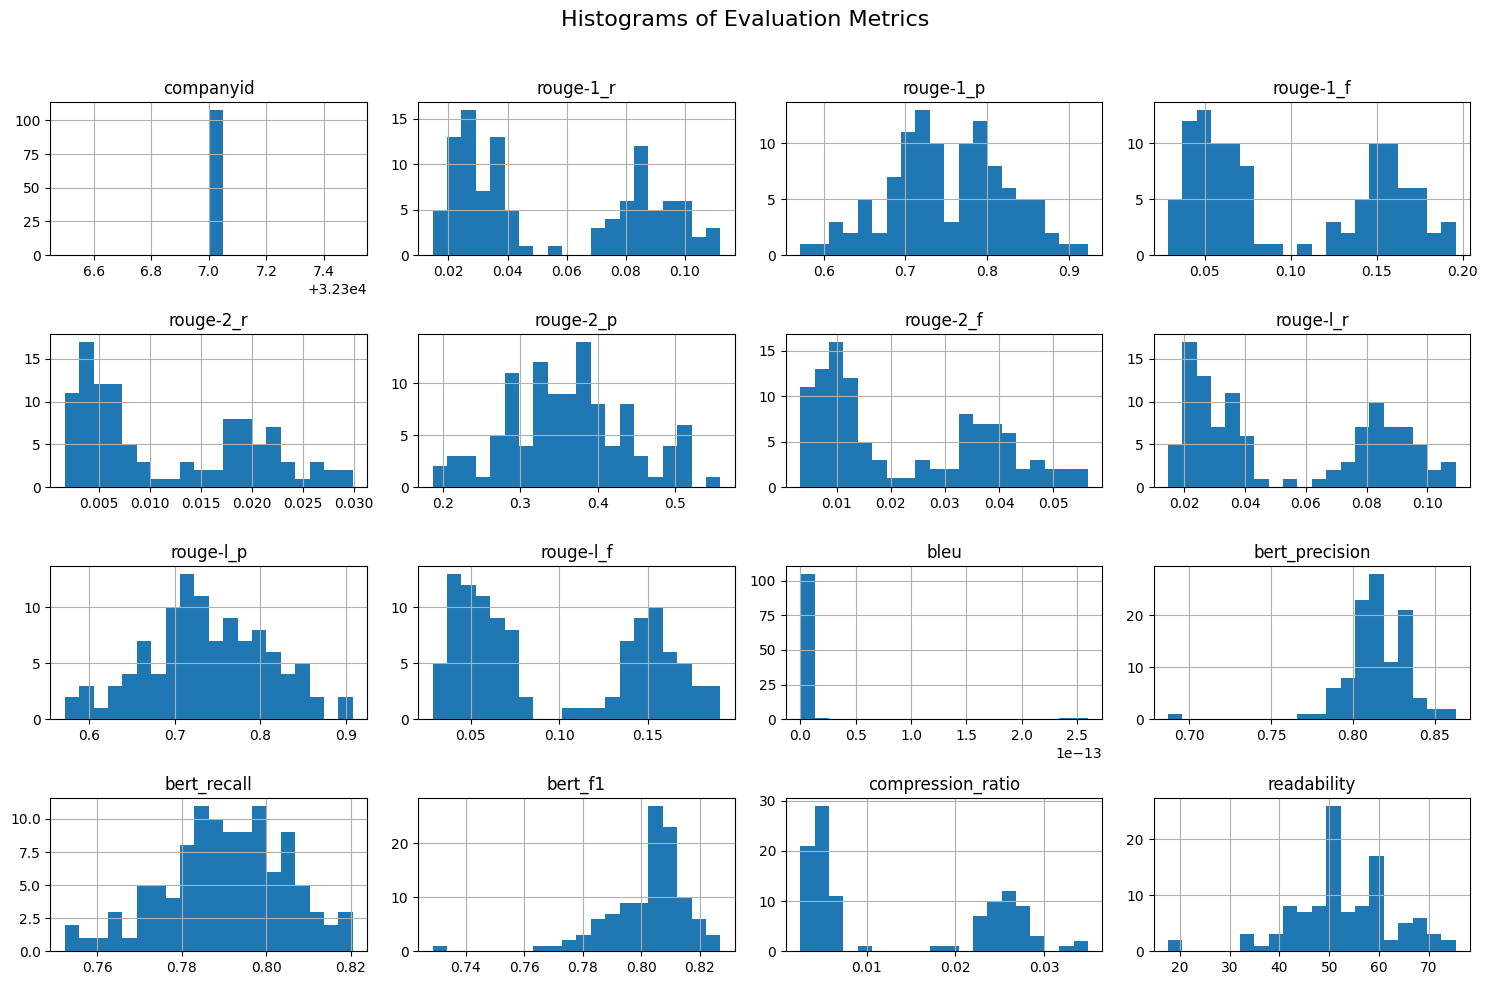

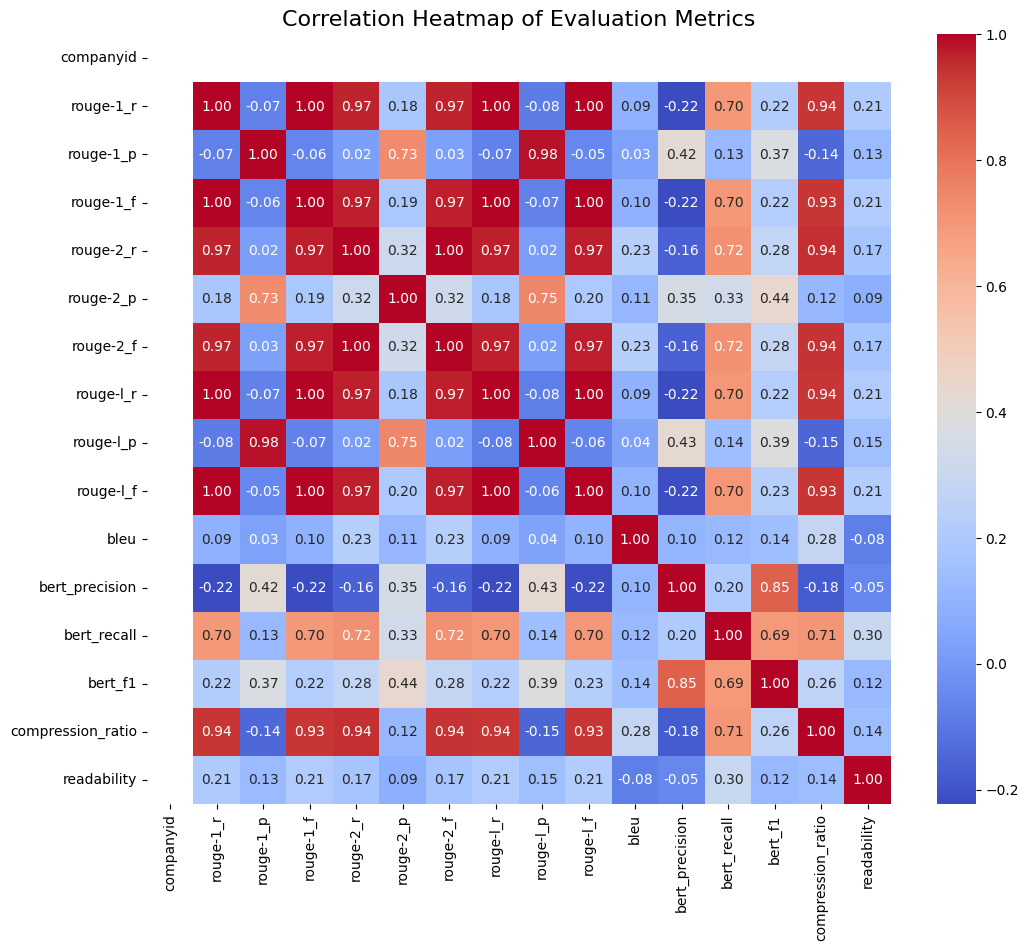

In [55]:
def visualize_results(df):
    """
    Visualizes evaluation metrics stored in a DataFrame.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing evaluation results with numeric metric columns.
    
    This function produces:
    - Histograms for each numeric metric.
    - A correlation heatmap of the numeric metrics.
    """
    # Select numeric columns (ignoring non-numeric columns such as model_name, uuid, etc.)
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    
    # Plot histograms for each numeric metric
    df[numeric_cols].hist(bins=20, figsize=(15, 10))
    plt.suptitle("Histograms of Evaluation Metrics", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
    # Plot a correlation heatmap of the numeric metrics
    plt.figure(figsize=(12, 10))
    correlation_matrix = df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Heatmap of Evaluation Metrics", fontsize=16)
    plt.show()

visualize_results(evaluation_results)

In [56]:
df.to_csv(
        Path("..") / "data" / f"{company_id}_summarized.csv",
        sep='\t',
        index=False,
        quoting=1,
        escapechar='\\',
        doublequote=True,
        quotechar='"',
        lineterminator='\n'
    )

In [ ]:
df.full_text[0]

"Analysts: All right. Why don't we go ahead and get started? Good morning, Happy New Year, and welcome to JPMorgan's 21st Annual Technology and Automotive Investor Forum here at the Consumer Electronics Show. My name is Harlan Sur. I'm the semiconductor and semiconductor capital equipment analyst for the firm. \nVery pleased to introduce Colette Kress, Executive Vice President and Chief Financial Officer at NVIDIA. It's been a tradition 9 years to have the NVIDIA team, specifically Colette, be the first to present at our investor conference, because the team is driving many of the trends that you're going to hear about today, right. Artificial intelligence, compute acceleration, next-generation compute platforms in automotive, in gaming and IoT. And in addition to that, the NVIDIA team is driving an emerging software and services revenue stream.\nSo I've asked Colette to start us off with an overview of what the team announced on Tuesday at its CES special address, and then we'll go ah

In [58]:
df[summary_column][0]

"Colette Kress, Executive Vice President and Chief Financial Officer, will present. DLSS is in its third generation, similar to ray tracing architecture Analysts ask about product cycles, diversification Nvidia sees inflection in gaming, ProViz businesses Q4 or Q4 will be near normal channel levels: CEO Analysts ask if Grace will be available in first half of 2019. Q&A with Nvidia executives on Grace and other projects Intel releases third generation of Ivy Bridge architecture. Nadella: Software is important, but services and ratable are low CEO: We are seeing more of a disruption in the short term. Q&A with executives at Apple follows: I want to start with some of the key things that we have been working on. CEO says Morgan Stanley is not here for auto folks. Gaming is powered by Unity engine Analysts ask about product cycles, diversification. ‘Growth is still here to go forward’: Fiat Chrysler CEO Q: Is there a focus on getting more products to market? Recommender systems still very 